# Tree-Based Methods

## Agenda
- Decision Trees
- Bagging
- Random Forests
- Trees for Regression


In [1]:
import urllib.request
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn import tree

# Suppress all warnings
warnings.filterwarnings('ignore')



## Plot Functions

In [4]:
def plot_tree(model, features):
    plt.figure(figsize=(15, 10))
    tree.plot_tree(
        model,
        feature_names=features,
        proportion=True,
        precision=2,
        filled=True,
    )
    plt.show()


In [5]:
def plot_tree_scatter(model, df, target, feat1, feat2, scatterplot=True):
    fig, ax = plt.subplots(figsize=(10, 6))

    if scatterplot:
        sns.scatterplot(x=feat1, y=feat2, hue=target, data=df)

    x_min = df[feat1].min()
    x_max = df[feat1].max()
    y_min = df[feat2].min()
    y_max = df[feat2].max()
    node_bounds = {0: (x_min, x_max, y_min, y_max)}

    for node in range(model.tree_.node_count):
        curr_x_min, curr_x_max, curr_y_min, curr_y_max = node_bounds[node]

        if model.tree_.feature[node] == -2:
            center_x = (curr_x_min + curr_x_max) / 2
            center_y = (curr_y_min + curr_y_max) / 2

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                # Check if model is regressor or classifier
                if hasattr(model, "predict_proba"):
                    # For classifier
                    prob_positive = model.predict_proba([[center_x, center_y]])[0][1]
                    color = plt.cm.coolwarm(prob_positive)
                else:
                    # For regressor
                    prediction = model.predict([[center_x, center_y]])[0]
                    # Normalize prediction to [0,1] for coloring
                    pred_min = df[target].min()
                    pred_max = df[target].max()
                    normalized_pred = (prediction - pred_min) / (pred_max - pred_min)
                    color = plt.cm.coolwarm(normalized_pred)

            plt.gca().add_patch(
                plt.Rectangle(
                    (curr_x_min, curr_y_min),
                    curr_x_max - curr_x_min,
                    curr_y_max - curr_y_min,
                    color=color,
                    alpha=0.3,
                )
            )
        else:
            feature = model.tree_.feature[node]
            threshold = model.tree_.threshold[node]

            if feature == 0:
                plt.plot([threshold, threshold], [curr_y_min, curr_y_max], "k--")
                node_bounds[model.tree_.children_left[node]] = (
                    curr_x_min,
                    threshold,
                    curr_y_min,
                    curr_y_max,
                )
                node_bounds[model.tree_.children_right[node]] = (
                    threshold,
                    curr_x_max,
                    curr_y_min,
                    curr_y_max,
                )
            elif feature == 1:
                plt.plot([curr_x_min, curr_x_max], [threshold, threshold], "r--")
                node_bounds[model.tree_.children_left[node]] = (
                    curr_x_min,
                    curr_x_max,
                    curr_y_min,
                    threshold,
                )
                node_bounds[model.tree_.children_right[node]] = (
                    curr_x_min,
                    curr_x_max,
                    threshold,
                    curr_y_max,
                )
    return ax

## Preparing the data

The dataset can only be downloaded as a zip file. Let's download, unzip, and open it.


In [6]:
url = "https://archive.ics.uci.edu/static/public/2/adult.zip"
urllib.request.urlretrieve(url, "adult.zip")

with zipfile.ZipFile("adult.zip", "r") as zip_ref:
    zip_ref.extractall("adults")

columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# the dataset is pre-split into train and test
# I want to do the split myself, so let's join the datasets
df1 = pd.read_csv("adult.data", header=None, names=columns)
# first row of adult.test is weird, let's remove it
df2 = pd.read_csv("adult.test", header=None, names=columns)[1:]
df = pd.concat([df1, df2])

In [7]:
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14281,43,Private,483450.0,9th,5.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,Mexico,<=50K
1166,46,Private,224582.0,Some-college,10.0,Never-married,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,52.0,United-States,<=50K.
6388,35,Local-gov,182074.0,HS-grad,9.0,Separated,Protective-serv,Not-in-family,White,Male,0.0,0.0,42.0,United-States,<=50K.
2277,28,Private,437994.0,Some-college,10.0,Never-married,Other-service,Not-in-family,Black,Male,0.0,0.0,60.0,United-States,<=50K.
4487,20,Private,22966.0,Some-college,10.0,Never-married,Other-service,Own-child,White,Male,0.0,0.0,12.0,Canada,<=50K


There's one column with a mysterious and undocumented column `fnlwgt`, let's drop it.

In [8]:
df = df.drop(columns=["fnlwgt"])

Some columns have dashes (-) instead of underscores in their names. I don't like that, so I'll rename the columns to use underscores.

In [9]:
df = df.rename(columns=lambda x: x.replace("-", "_"))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  object 
 1   workclass       48842 non-null  object 
 2   education       48842 non-null  object 
 3   education_num   48842 non-null  float64
 4   marital_status  48842 non-null  object 
 5   occupation      48842 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   capital_gain    48842 non-null  float64
 10  capital_loss    48842 non-null  float64
 11  hours_per_week  48842 non-null  float64
 12  native_country  48842 non-null  object 
 13  income          48842 non-null  object 
dtypes: float64(4), object(10)
memory usage: 5.6+ MB


There are no null values in the columns, but from the column description [here](https://archive.ics.uci.edu/dataset/2/adult) I see that some of them have missing values. Maybe the missing values are encoded differently? 

In [11]:
df.sample(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
16523,79,?,HS-grad,9.0,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
14776,35,State-gov,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Male,0.0,0.0,45.0,United-States,<=50K.
15722,50,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
21926,28,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,42.0,United-States,<=50K
12575,38,Self-emp-inc,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298.0,0.0,40.0,United-States,>50K
25798,22,Private,Some-college,10.0,Never-married,Sales,Own-child,White,Female,0.0,0.0,35.0,United-States,<=50K
23865,67,?,10th,6.0,Never-married,?,Not-in-family,Black,Female,0.0,0.0,35.0,United-States,<=50K
5093,57,Self-emp-not-inc,11th,7.0,Divorced,Other-service,Unmarried,White,Male,4650.0,0.0,50.0,United-States,<=50K.
15869,64,Private,11th,7.0,Divorced,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K.
10014,24,Private,Some-college,10.0,Never-married,Sales,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K


Indeed, "?" seems to represent a missing value. In fact, it's " ?" (with a space).

In [12]:
# Replace "?" with NaN in all columns
df = df.replace(" ?", None)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  object 
 1   workclass       46043 non-null  object 
 2   education       48842 non-null  object 
 3   education_num   48842 non-null  float64
 4   marital_status  48842 non-null  object 
 5   occupation      46033 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   capital_gain    48842 non-null  float64
 10  capital_loss    48842 non-null  float64
 11  hours_per_week  48842 non-null  float64
 12  native_country  47985 non-null  object 
 13  income          48842 non-null  object 
dtypes: float64(4), object(10)
memory usage: 5.6+ MB


In [14]:
df["income"].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [15]:
# map target to more usable 0/1
df["income"] = df["income"].str.strip().str.replace(".", "")
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})

# Convert age column to integer type
df["age"] = df["age"].astype(int)

In [16]:
df["sex"].value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

In [17]:
df["sex"] = df["sex"].map({" Male": 1, " Female": 0})

The dataset is now ready for analysis and modelling!

In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)

## Decision trees

Decision trees is a very simple algorithm that works based on splitting the feature space. Let's fit our first decision tree.


In [19]:
from sklearn.tree import DecisionTreeClassifier

features = ["education_num", "hours_per_week"]
X = df_train[features]
y = df_train["income"]

model = DecisionTreeClassifier(
    max_depth=2, random_state=42
)  # increase from 1 to 3 and see what happens
model.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

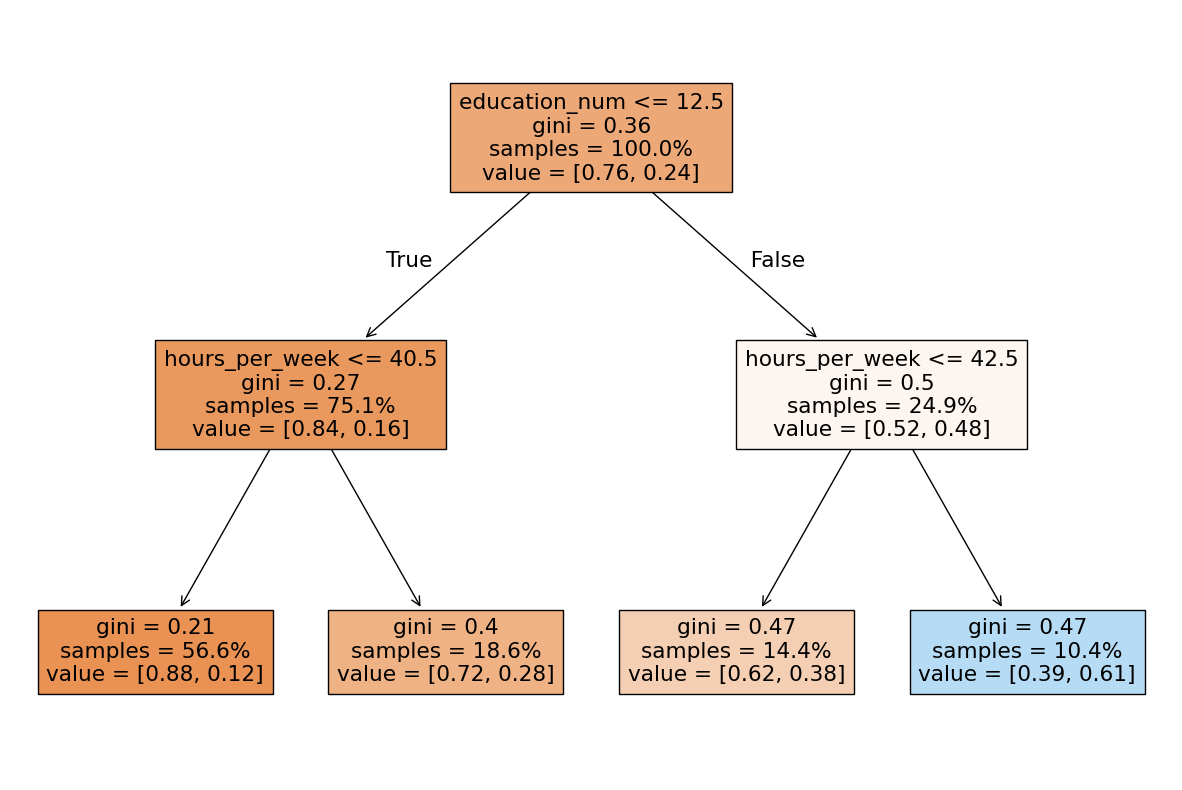

In [20]:
plot_tree(model, features=["education_num", "hours_per_week"])

The tree above is our model. We can use it to make predictions by going down the tree, treating each node as an if statement, until we reach the terminal node also called the leaf. Then our predicted probabilities are indicated by the `value` in that terminal node. 

In this case, only the node on the very right would give a prediction of income being a positive class above 50%. Namely, it would be 61%, which is also simply the proportion of positive class cases in that leaf.

Another way to visualize our model is by looking at how it splits the feature space.


<Axes: xlabel='education_num', ylabel='hours_per_week'>

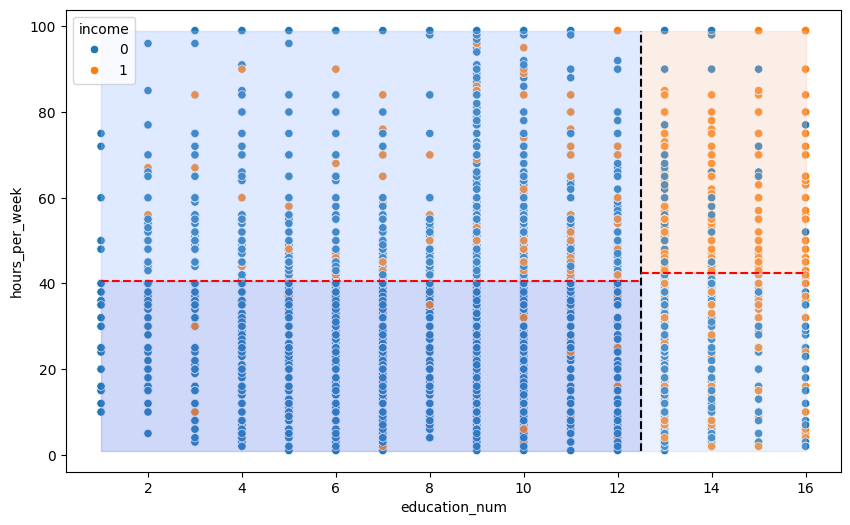

In [21]:
plot_tree_scatter(model, df_train, "income", "education_num", "hours_per_week")


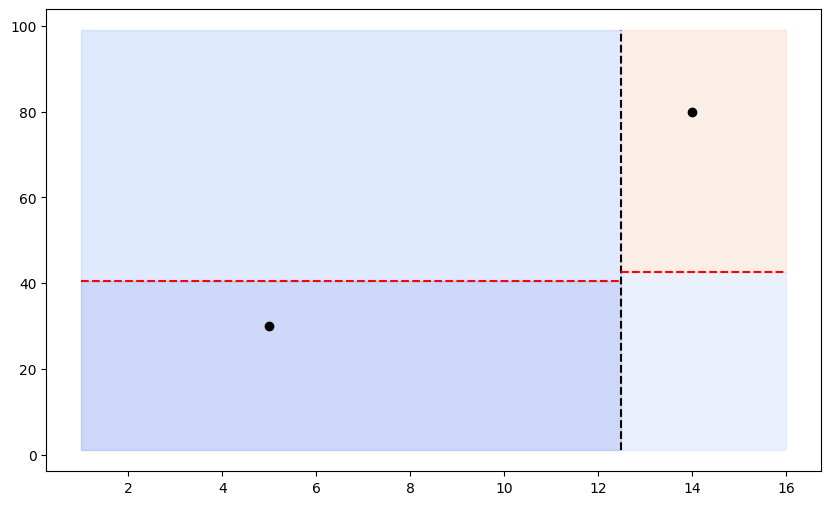

In [22]:
ax = plot_tree_scatter(
    model, df_train, "income", "education_num", "hours_per_week", scatterplot=False
)
ax.plot(5, 30, "ko")  # Add black dot at point (40,5)
ax.plot(14, 80, "ko")


### Task

Find the optimal max_depth value. Use GridSearchCV.


{'max_depth': 6}


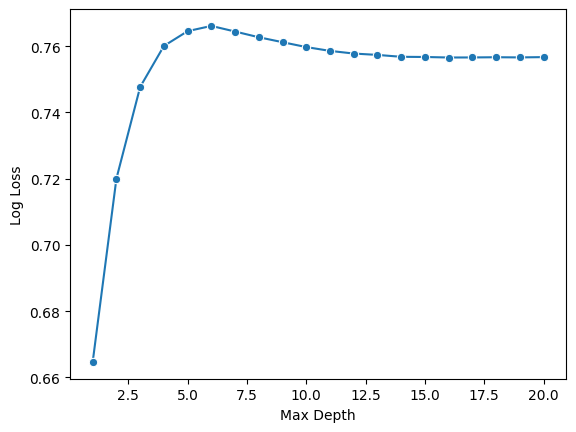

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": range(1, 21)}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X, y)

plot_df = pd.DataFrame(
    {"Max Depth": range(1, 21), "Log Loss": grid_search.cv_results_["mean_test_score"]}
)

# Plot using seaborn
sns.lineplot(data=plot_df, x="Max Depth", y="Log Loss", marker="o")

print(grid_search.best_params_)


## Bagging

Bagging is an algorithm that fits multiple decision trees. To make each tree different, we use a bootstrapped dataset instead of the original dataset.

In other words, for `n_estimators` times:
1. Create a bootstrapped dataset by sampling from the original dataset with resampling.
2. Fit a decision tree.


In [30]:
from sklearn.model_selection import cross_val_score

dec_model = DecisionTreeClassifier(max_depth=6) # equivalent to passing max_depth=6
dec_model.fit(X, y)

np.mean(cross_val_score(dec_model, X, y, cv=5, scoring="roc_auc"))


np.float64(0.766140879559793)

In [32]:
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=6), n_estimators=5, random_state=42
)

bag_model.fit(X, y)
np.mean(cross_val_score(bag_model, X, y, cv=5, scoring="roc_auc"))

np.float64(0.7668979418301902)

We can now look at individual trees from the bagging classifier and plot them on a scatterplot (the trees are too deep for a tree plot). Notice how each tree is different.



<Axes: xlabel='education_num', ylabel='hours_per_week'>

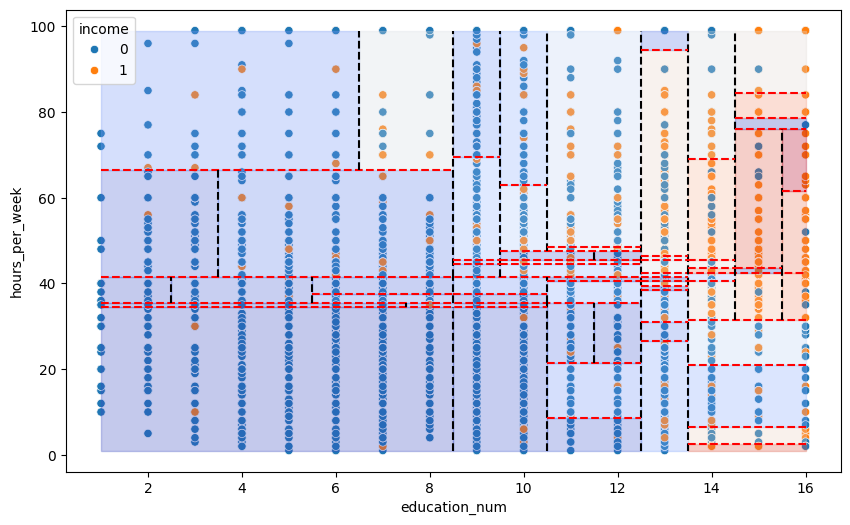

In [34]:
plot_tree_scatter(
    bag_model.estimators_[1], df_train, "income", "education_num", "hours_per_week"
)


Text(0.5, 1.0, 'Bagging Performance vs Number of Estimators')

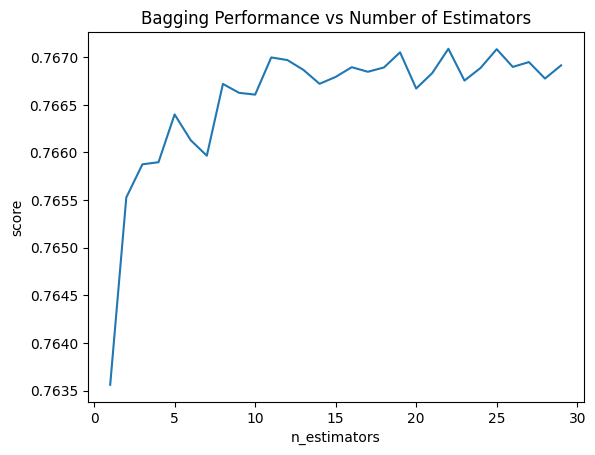

In [38]:
import seaborn as sns
import pandas as pd

N = range(1, 30)
all_scores = []

for i in N:
    bagging_model = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=6), n_estimators=i
    )
    scores = cross_val_score(bagging_model, X, y, cv=5, scoring="roc_auc")
    all_scores.append({"n_estimators": i, "score": scores.mean()})

plot_df = pd.DataFrame(all_scores)
sns.lineplot(data=plot_df, x="n_estimators", y="score")
plt.title("Bagging Performance vs Number of Estimators")

## Random Forests

**Training**. Repeat `n_estimators` times:
1. Build a bootstrap dataset
2. Fit a decision tree until a stopping criteria is met, but on each split only choose from `max_features` random features.

Essentially, we're performing bagging, but with the additional step of choosing splits from random candidate features, rather than all features.

Stopping criteria can be:
1. `max_depth` - what is the maximum depth that a tree can reach?
2. `min_samples_split` - how many samples does a node have to have to be considered for splitting?
3. `min_impurity_decrease` - what is the minimum reduction in impurity (e.g. Gini coefficient) for a split to happen?

After training we have multiple decision trees, all of which are likely different from each other. We have our random forest.

**Predicting**. For each of the `n_estimators` trees, make a prediction. Return the majority vote or average probability from each of the individual decision trees.



In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)

np.mean(cross_val_score(rf_model, X, y, cv=5, scoring="roc_auc"))


np.float64(0.767404430830976)

### Task

Fit a RandomForest classifier with n_estimators=10, using the listed features as predictors. Evaluate the model via cross validation.

In RandomForestClassifier you can set `n_jobs=-1` to speed up training.

Keep in mind that unlike last week, we do not need to apply scaling and polynomial transformations. The only preprocessing you need is one-hot encoding for categorical features.


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

categorical_features = ["workclass", "education", "occupation", "race"]
numeric_features = ["age", "education_num", "hours_per_week", "capital_gain"]


In [50]:
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", max_categories=10, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="passthrough"  # Keep numeric features as is
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=20, n_jobs=-1))
])

X = df_train[categorical_features + numeric_features]
y = df_train["income"]

rf_score = np.mean(cross_val_score(pipeline, X, y, cv=5, scoring="roc_auc"))
print(f"Random Forest ROC AUC: {rf_score:.4f}")


Random Forest ROC AUC: 0.8082


### Task

Tune the max_depth and class_weight hyperparameters. Fit a model with the optimal hyperparameters.


In [51]:
param_grid = {
    "rf__max_depth": ...,
    "rf__class_weight": ["balanced", None]
}

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "rf__max_depth": range(1, 21),
    "rf__class_weight": ["balanced", None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X, y)

print(grid_search.best_params_)


{'rf__class_weight': None, 'rf__max_depth': 13}


In [53]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=12, class_weight=None))
])
pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=10))]),
                                                  ['workclass', 'education',
                                                   'occupation', 'race'])])),
                ('rf',
                 RandomForestClassifier(max_depth=12, n_estimators=20,
                                        n_jobs=-1))])

### Task

Report the results on the test set.
1. Report the metrics for a threshold of 0.5.
2. Show via a plot how the metrics change as you change the threshold.


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_test = df_test[categorical_features + numeric_features]
y_test = df_test["income"]

y_score = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_score >= 0.5).astype(int)

print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

thresholds = np.linspace(0, 1, 10)
scores = []
for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    scores.append(
        {
            "threshold": threshold,
            "f1_score": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred)
        }
    )
threshold_df = pd.DataFrame(scores)

plt.figure(figsize=(10, 6))
sns.lineplot(data=threshold_df, x='threshold', y='f1_score', label='F1 Score')
sns.lineplot(data=threshold_df, x='threshold', y='precision', label='Precision')
sns.lineplot(data=threshold_df, x='threshold', y='recall', label='Recall')


NameError: name 'categorical_features' is not defined

## Regression Trees


In [72]:
df_hit = pd.read_csv(
    "https://raw.githubusercontent.com/intro-stat-learning/ISLP/main/ISLP/data/Hitters.csv"
)
df_hit = df_hit[df_hit["Salary"].notnull()]

In [73]:
y = df_hit["Salary"]
X = df_hit[["Years", "RBI"]]

In [74]:
from sklearn.tree import DecisionTreeRegressor

In [75]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(X, y)

DecisionTreeRegressor(max_depth=2)

<Axes: xlabel='Years', ylabel='RBI'>

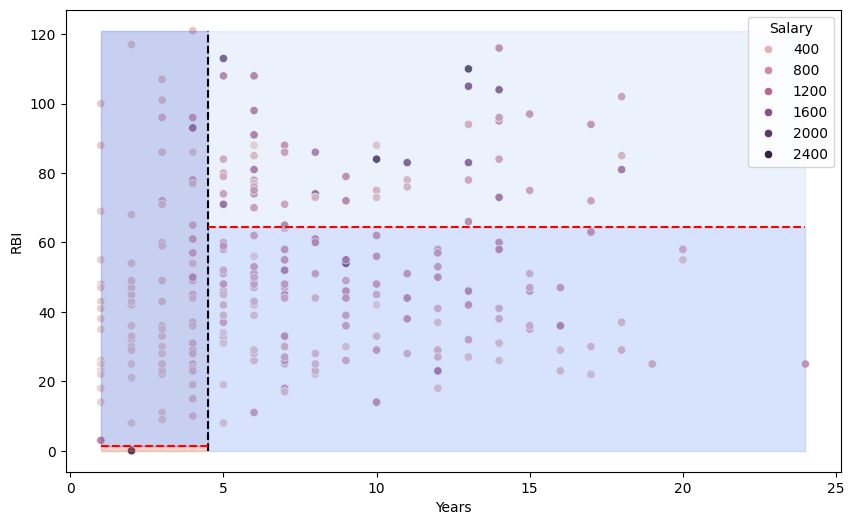

In [76]:
plot_tree_scatter(model, df_hit, "Salary", "Years", "RBI")
